# Exploratory Data Analysis (EDA)

In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx

from pathlib import Path

In [2]:
dataset = xr.open_zarr(Path.home() / 'hdd1/seasfire/SeasFireCube8daily.zarr', consolidated=False)
dataset

<xarray.Dataset>
Dimensions:             (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * latitude            (latitude) float64 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude           (longitude) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 2001-01-01T12:00:00 ... 2021-12...
Data variables: (12/36)
    BAs_GWIS            (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    BurntArea           (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCCI_BA             (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCD_emissions       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FRP_emissions       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    LST_Day_CMG         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                  ...
    t2mmax              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2mmin              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd_cf              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    wp                  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>

## Descriptive Statistical Analysis

In [3]:
def select_spatio_temporal_data(dataset, initial_timestep, timesteps, latitude=-1, longitude=-1):
    '''
    Desc
    ----
    Method to select a subset of the cube.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1    
    '''
    
    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))
    
    return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=slice(0,latitude), longitude=slice(0,longitude))

In [4]:
def select_variable_data(dataset, variable_name):
    '''
    Desc
    ----
    Method to select a particular variable (such as relaive humidity, windspeed, sst etc)
    from the DataCube.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    '''
    
    return dataset[variable_name]

In [5]:
def check_nan_values(pandas_df, variable_name):
    '''
    Desc
    ----
    Method to check if there are Nan values in a specific column of a pandas dataframe. 
    If Nan values exist, it drops all rows with Nan values on the specific column.
    
    Args
    ----
    pandas_df: pandas.Dataframe
        * the dataset from which we want the descriptive statistics of the selected variable
    variable name: string
        * name of the selected variable
        
    Return
    ----
    Returns the dataframe without Nan values.
    '''
    
    if pandas_df[variable_name].isnull().values.any():
        pandas_df = pandas_df.dropna()
        
    return pandas_df

In [6]:
def to_pandas(dataset, variable_name, initial_timestep, timesteps):
    wanted_part = select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                              initial_timestep, 
                                              timesteps, 
                                              latitude= -1, 
                                              longitude = -1)
    
    print("Time period: ", (wanted_part['time'].values)[0], "-", (wanted_part['time'].values)[-1])
    pandas_df = wanted_part.to_dataframe()
    
    del(wanted_part)
    
    return pandas_df

In [7]:
def calculate_values(pandas_df, variable_name):
    '''
    Desc
    ----
    Method to calculate the below values for a pandas dataframe:
    * min       * mode
    * max       * standard deviation (std)
    * mean      * skewness
    * median
    
    Args
    ----
    pandas_df: pandas.Dataframe
        * the dataset from which we want the descriptive statistics of the selected variable
    variable name: string
        * name of the selected variable
    '''
    mean_value = pandas_df[variable_name].mean(skipna=False)
    maximum_value = pandas_df[variable_name].max(skipna=False)
    minimum_value = pandas_df[variable_name].min(skipna=False)
#     median_value = pandas_df[variable_name].median(skipna=False)
#     mode_value = pandas_df[variable_name].mode(dropna=False)
#     std_value = pandas_df[variable_name].std(skipna=False)
#     skew_value = pandas_df[variable_name].skew(skipna=False)
    
    print(maximum_value)
    print(minimum_value)
    print(mean_value)
#     print("Range of values: (", minimum_value, ",", maximum_value, ")")
#     print("Mean value: ", mean_value)
#     print("Median value: ", median_value)
#     print("Mode value: ", mode_value)
#     print("Std value: ", std_value)
#     print("Skewness value: ", skew_value)

In [8]:
def descriptive_statistics(dataset, variable_name, initial_timestep, timesteps):
    '''
    Desc
    ----
    Method for descriptive statistical analysis for an xarray.Dataset.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the descriptive statistics of the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    '''
    
#     wanted_part = select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
#                                               initial_timestep, 
#                                               timesteps, 
#                                               latitude= -1, 
#                                               longitude = -1)
    
#     print("Time period: ", (wanted_part['time'].values)[0], "-", (wanted_part['time'].values)[-1])
#     pandas_df = wanted_part.to_dataframe()
    
    pandas_df = to_pandas(dataset, variable_name, initial_timestep, timesteps)
    pandas_df = check_nan_values(pandas_df, variable_name)
    pandas_df = pandas_df[pandas_df[variable_name] != -9999]
    
    calculate_values(pandas_df, variable_name)

    del(pandas_df)

In [9]:
descriptive_statistics(dataset, 'Pop_dens', 920, 46)

Time period:  2021-01-01T12:00:00.000000000 - 2021-12-27T12:00:00.000000000
27643.41
0.0
55.91421


In [10]:
(dataset['t2m'].time.values[0]).astype(object).year

AttributeError: 'int' object has no attribute 'year'

In [66]:
test = dataset['t2m'].time.values
date_list = pd.to_datetime(test).month
date_list = date_list.astype(str)

In [64]:
test = dataset['t2m'].time.values
date_list = pd.to_datetime(test).year
date_list

Int64Index([2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', length=966)

In [48]:
print(type(date_list[0]))

<class 'str'>


In [49]:
from collections import Counter

In [67]:
for i in range (0,21):
    
    part = date_list[46*i :46*(i+1)]
    res = Counter(part)
    
    print(res)

Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2': 4, '3': 4, '4': 4, '6': 4, '7': 4, '8': 4, '9': 4, '10': 4, '12': 4, '5': 3, '11': 3})
Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2': 4, '3': 4, '4': 4, '6': 4, '7': 4, '8': 4, '9': 4, '10': 4, '12': 4, '5': 3, '11': 3})
Counter({'1': 4, '2': 4, '3': 4, '5': 4, '6': 4, '7': 4, '8': 4, '9': 4, '11': 4, '12': 4, '4': 3, '10': 3})
Counter({'1': 4, '2

In [55]:
date_list = [4,4,4,3,4,4,4,4,4,3,4,4]

In [58]:
date_list.count(3)

2

In [71]:
from termcolor import colored

In [70]:
pip install termcolor

  Preparing metadata (setup.py) ... done
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=7f264b2215eb0ba0afcf5e24f54f63c4868bc6547d322940c1c6870353bffe57
  Stored in directory: /home/jupyter-eleanna.panagiotou-c61c4/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
'LST_Day_CMG'

In [79]:
for i in range (0,21):
        print(colored("Year: "+ str((2001+i)), attrs=['bold']))
        
        if(2001+i == 2004 or 2001+i == 2008 or 2001+i == 2012 or 2001+i == 2016 or 2001+i == 2020):
            date_list = [4,4,4,4,3,4,4,4,4,4,3,4]
        else :
            date_list = [4,4,4,3,4,4,4,4,4,3,4,4]
        
        for j in range (0,12):
            if ((date_list[j] == 3) and (3 in date_list[:j])):
                print(4)
                descriptive_statistics(dataset, 'LST_Day_CMG', (46*i) + (date_list[j-1]*j) - 1, date_list[j])
            elif((3 in date_list[:j]) and (j!=0)):
                print(2)
                if(date_list[:j].count(3) > 1):
                    descriptive_statistics(dataset, 'LST_Day_CMG', (46*i) + (date_list[j]*j) - 2, date_list[j])
                else:
                    descriptive_statistics(dataset, 'LST_Day_CMG', (46*i) + (date_list[j]*j) - 1, date_list[j])
            elif(date_list[j] == 3):
                print(1)
                descriptive_statistics(dataset, 'LST_Day_CMG', (46*i) + (date_list[j-1]*j), date_list[j])
            else:
                print(3)
                descriptive_statistics(dataset, 'LST_Day_CMG', (46*i) + (date_list[j]*j), date_list[j])
            print("-----------------")
    
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Year: 2001
3
Time period:  2001-01-01T12:00:00.000000000 - 2001-01-25T12:00:00.000000000
16654.715
10620.571
13321.643
-----------------
3
Time period:  2001-02-02T12:00:00.000000000 - 2001-02-26T12:00:00.000000000
16676.0
10490.0
13284.26
-----------------
3
Time period:  2001-03-06T12:00:00.000000000 - 2001-03-30T12:00:00.000000000
16624.834
9997.0
13378.901
-----------------
1
Time period:  2001-04-07T12:00:00.000000000 - 2001-04-23T12:00:00.000000000
16846.334
9817.0
13489.051
-----------------
2
Time period:  2001-05-01T12:00:00.000000000 - 2001-05-25T12:00:00.000000000
16998.375
9729.75
13672.965
-----------------
2
Time period:  2001-06-02T12:00:00.000000000 - 2001-06-26T12:00:00.000000000
17008.5
9407.0
13714.725
-----------------
2
Time period:  2001-07-04T12:00:00.000000000 - 2001-07-28T12:00:00.000000000
16945.0
9495.0
13832.477
-----------------
2
Time period:  2001-08-05T12:00:00.000000000 - 2001-08-29T12:00:00.000000000
16952.0
9538.0
13732.85
-----------------
2
Time per

In [82]:
list(dataset.variables)

['BAs_GWIS',
 'BurntArea',
 'FCCI_BA',
 'FCD_emissions',
 'FRP_emissions',
 'LST_Day_CMG',
 'Lai',
 'NDVI',
 'Pop_dens',
 'censo',
 'drought_code_max',
 'ea',
 'epo',
 'fwi',
 'gmsst',
 'latitude',
 'longitude',
 'mean_fwi',
 'mslp',
 'nao',
 'nina34_anom',
 'pdo',
 'pna',
 'population_density',
 'rH_cf',
 'skt',
 'soi',
 'ssr',
 'ssrd',
 'sst',
 'swvl1',
 't2m',
 't2mmax',
 't2mmin',
 'time',
 'tp',
 'vpd_cf',
 'wp',
 'ws10']

In [84]:
for variable in list(dataset.variables)[5:]:
    print(colored("Variable: "+variable, attrs=['bold']))
    for i in range (0,21):
        print(colored("Year: "+ str((2001+i)), attrs=['bold']))
        
        if(2001+i == 2004 or 2001+i == 2008 or 2001+i == 2012 or 2001+i == 2016 or 2001+i == 2020):
            date_list = [4,4,4,4,3,4,4,4,4,4,3,4]
        else :
            date_list = [4,4,4,3,4,4,4,4,4,3,4,4]
        
        for j in range (0,12):
            if ((date_list[j] == 3) and (3 in date_list[:j])):
                print(4)
                descriptive_statistics(dataset, variable, (46*i) + (date_list[j-1]*j) - 1, date_list[j])
            elif((3 in date_list[:j]) and (j!=0)):
                print(2)
                if(date_list[:j].count(3) > 1):
                    descriptive_statistics(dataset, variable, (46*i) + (date_list[j]*j) - 2, date_list[j])
                else:
                    descriptive_statistics(dataset, variable, (46*i) + (date_list[j]*j) - 1, date_list[j])
            elif(date_list[j] == 3):
                print(1)
                descriptive_statistics(dataset, variable, (46*i) + (date_list[j-1]*j), date_list[j])
            else:
                print(3)
                descriptive_statistics(dataset, variable, (46*i) + (date_list[j]*j), date_list[j])
            print("-----------------")
    
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Variable: LST_Day_CMG
Year: 2001
3
Time period:  2001-01-01T12:00:00.000000000 - 2001-01-25T12:00:00.000000000
16654.715
10620.571
13321.643
-----------------
3
Time period:  2001-02-02T12:00:00.000000000 - 2001-02-26T12:00:00.000000000
16676.0
10490.0
13284.26
-----------------
3
Time period:  2001-03-06T12:00:00.000000000 - 2001-03-30T12:00:00.000000000
16624.834
9997.0
13378.901
-----------------
1
Time period:  2001-04-07T12:00:00.000000000 - 2001-04-23T12:00:00.000000000
16846.334
9817.0
13489.051
-----------------
2
Time period:  2001-05-01T12:00:00.000000000 - 2001-05-25T12:00:00.000000000
16998.375
9729.75
13672.965
-----------------
2
Time period:  2001-06-02T12:00:00.000000000 - 2001-06-26T12:00:00.000000000
17008.5
9407.0
13714.725
-----------------
2
Time period:  2001-07-04T12:00:00.000000000 - 2001-07-28T12:00:00.000000000
16945.0
9495.0
13832.477
-----------------
2
Time period:  2001-08-05T12:00:00.000000000 - 2001-08-29T12:00:00.000000000
16952.0
9538.0
13732.85
------

ValueError: Dimensions {'time'} do not exist. Expected one or more of ('latitude',)

In [78]:
for variable in dataset.variables:
    print(colored("Variable: "+variable, attrs=['bold']))
    for i in range (0,21):
        print(colored("Year: "+ str((2001+i)), attrs=['bold']))
        
        if(2001+i == 2004 or 2001+i == 2008 or 2001+i == 2012 or 2001+i == 2016 or 2001+i == 2020):
            date_list = [4,4,4,4,3,4,4,4,4,4,3,4]
        else :
            date_list = [4,4,4,3,4,4,4,4,4,3,4,4]
        
        for j in range (0,12):
            if ((date_list[j] == 3) and (3 in date_list[:j])):
                print(4)
                descriptive_statistics(dataset, variable, (46*i) + (date_list[j-1]*j) - 1, date_list[j])
            elif((3 in date_list[:j]) and (j!=0)):
                print(2)
                if(date_list[:j].count(3) > 1):
                    descriptive_statistics(dataset, variable, (46*i) + (date_list[j]*j) - 2, date_list[j])
                else:
                    descriptive_statistics(dataset, variable, (46*i) + (date_list[j]*j) - 1, date_list[j])
            elif(date_list[j] == 3):
                print(1)
                descriptive_statistics(dataset, variable, (46*i) + (date_list[j-1]*j), date_list[j])
            else:
                print(3)
                descriptive_statistics(dataset, variable, (46*i) + (date_list[j]*j), date_list[j])
            print("-----------------")
    
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Variable: BAs_GWIS
Year: 2001
3
Time period:  2001-01-01T12:00:00.000000000 - 2001-01-25T12:00:00.000000000
60539.176
0.0
8.720904
-----------------
3
Time period:  2001-02-02T12:00:00.000000000 - 2001-02-26T12:00:00.000000000
64980.39
0.0
3.853789
-----------------
3
Time period:  2001-03-06T12:00:00.000000000 - 2001-03-30T12:00:00.000000000
67695.25
0.0
2.1389244
-----------------
1
Time period:  2001-04-07T12:00:00.000000000 - 2001-04-23T12:00:00.000000000
69724.09
0.0
4.0098295
-----------------
2
Time period:  2001-05-01T12:00:00.000000000 - 2001-05-25T12:00:00.000000000
71242.94
0.0
4.065204
-----------------
2
Time period:  2001-06-02T12:00:00.000000000 - 2001-06-26T12:00:00.000000000
58680.67
0.0
7.5524173
-----------------
2
Time period:  2001-07-04T12:00:00.000000000 - 2001-07-28T12:00:00.000000000
73360.734
0.0
15.443632
-----------------
2
Time period:  2001-08-05T12:00:00.000000000 - 2001-08-29T12:00:00.000000000
73722.49
0.0
17.546314
-----------------
2
Time period:  200

KeyboardInterrupt: 

In [ ]:
for variable in dataset.variables:
    print("Variable: ", variable)
    for i in range (0,20):
        print("Year: ", 2001+i)
        descriptive_statistics(dataset, variable, 46*i, 46)
        print("~~~~~~~~~~~~~~~~")

In [101]:
print(variable in dataset.variables)

NameError: name 'variable' is not defined

In [71]:
dataset['Pop_dens']

<xarray.DataArray 'Pop_dens' (time: 966, latitude: 720, longitude: 1440)>
dask.array<open_dataset-188057359b81e230c141a5c4cc86da62Pop_dens, shape=(966, 720, 1440), dtype=float32, chunksize=(966, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 2001-01-01T12:00:00 ... 2021-12-27T12:00:00
Attributes:
    coordinates:  raster
    long_name:    UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010...
    max:          [2.73649963716e-312, 4.75385302251e-312, 1.377999785133e-31...
    min:          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0553e-...
    units:        Persons per square kilometer

## Data normalization 

In [11]:
def normalize_variable(df, variable_name):
    df = df[[variable_name]]
    df_norm = (df - df.min()) / (df.max() - df.min())
    
    return df_norm

In [23]:
# define a method to scale data, looping thru the columns, and passing a scaler
def scale_data(dataset, variable, initial_timestep, timesteps):
    
    df = to_pandas(dataset, variable, initial_timestep, timesteps)
    df = check_nan_values(df, variable)

    df_norm = normalize_variable(df, variable)
    
    del(df)
    
    return df_norm

## Data visualisation

In [58]:
def my_histogram(pandas_df, variable_name):
#     df = to_pandas(dataset, variable_name, initial_timestep, timesteps)
#     df = check_nan_values(df, variable_name)
    
    pandas_df.plot.hist(color='#0f4c5c')

In [ ]:
def my_boxplot(pandas_df, variable_name):
#     df = to_pandas(dataset, variable_name, initial_timestep, timesteps)
#     df = check_nan_values(df, variable_name)
    
    sns.boxplot(x=pandas_df[variable_name])

In [56]:
def plots(dataset, variables, initial_timestep, timesteps):
    
    for variable in variables:
        print(variable)
        df_norm = scale_data(dataset, variable, initial_timestep, timesteps)
        
        my_histogram(df_norm, variable)
        plt.show()
        my_boxplot(df_norm, variable)
        plt.show()
        
        del(df_norm)
        

t2m
Time period:  2001-01-01T12:00:00.000000000 - 2001-02-02T12:00:00.000000000


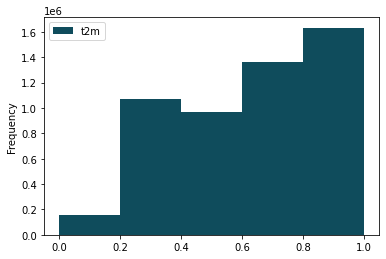

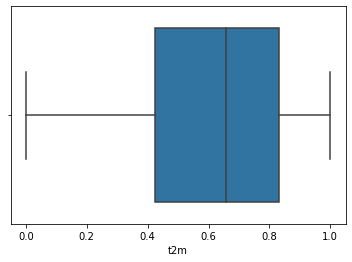

ws10
Time period:  2001-01-01T12:00:00.000000000 - 2001-02-02T12:00:00.000000000


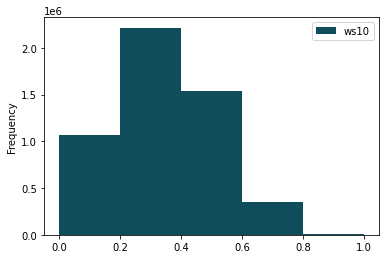

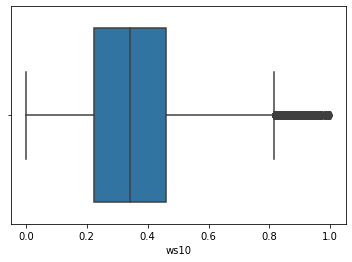

In [57]:
plots(dataset, ['t2m', 'ws10'], 0, 5)

## Results